In [1]:
import numpy as np
import pandas as pd
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

import theano
theano.config.openmp = True

%matplotlib inline
%env OMP_NUM_THREADS=12

Using Theano backend.


env: OMP_NUM_THREADS=12


In [2]:

def create_dataset_lags(dataset, signal, nblags=1):
    df = dataset.copy();
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        df[name] = dataset[signal].shift(i+1);
    return df

In [3]:
def load_dataset(source , signal):
    dataframe = pd.read_csv(source, engine='python')
    return dataframe ;

def get_lag_names(signal, nblags):
    names = [];
    for i in range(nblags):
        name = signal + "_" + str(i+1);
        names.append(name);
    return names;

def cut_dataset(dataframe , signal, lags):
    train_size = int(dataframe.shape[0] * 0.67)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(dataframe[signal][0:train_size].values.ravel())
    dataframe['scaled_' + signal] = scaler.transform(dataframe[signal].values.ravel())
    lagged_df = create_dataset_lags(dataframe, 'scaled_' + signal, lags)
    (train_df, test_df) = (lagged_df[0:train_size] , lagged_df[train_size:])

    return (scaler, train_df , test_df)

In [27]:
# create and fit the LSTM network

def train_model(train_df , signal, lags, epochs):
    model = Sequential()
    model.add(LSTM(lags, input_dim=lags))
    
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    lag_names = get_lag_names('scaled_' + signal , lags);
    N = train_df.shape[0] - lags
    NEstim = (N * 4) // 5;
    trainX = train_df[lag_names][lags:].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainY = train_df['scaled_' + signal][lags:].values
    estimX = trainX[0:NEstim]
    estimY = trainY[0:NEstim]
    valX = trainX[ NEstim : ]
    valY = trainY[ NEstim : ]

    lStopCallback = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    lHistory = model.fit(estimX, estimY, nb_epoch=epochs, batch_size=1, validation_data=(valX , valY), verbose=2, 
                        callbacks=[lStopCallback])
    print(lHistory.__dict__)
    return model;

def plot_model(model):
    from IPython.display import SVG
    from keras.utils.visualize_util import model_to_dot

    SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

    

In [28]:
# make predictions

def compute_L2_MAPE(signal , estimator):
    lMean = np.mean( (signal - estimator)**2 );
    lMAPE = np.mean( np.abs((signal - estimator) / signal ));
    lL2 = np.sqrt(lMean);
    return (lL2 , lMAPE);


def predict_signal(model, scaler, signal, nblags, train_df, test_df, idataframe):
    lag_names = get_lag_names('scaled_' + signal , nblags);
    trainX = train_df[lag_names].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    trainPredict = model.predict(trainX)
    testX = test_df[lag_names].values
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict[nblags:])
    testPredict = scaler.inverse_transform(testPredict)
    
    # calculate root mean squared error
    lTrainL2 = compute_L2_MAPE(train_df[signal][nblags:].values, trainPredict)
    lTestL2 = compute_L2_MAPE(test_df[signal].values, testPredict)
    print('TRAIN_TEST_RMSE_MAPE', lTrainL2 , lTestL2)

    out_df = pd.DataFrame()
    out_df = idataframe.copy();
    out_N = out_df.shape[0]
    out_df['Time'] = range(out_N)
    # out_df['scaled_output'] = 0;
    lSeries = pd.Series(np.full(nblags , np.nan));
    lSeries1 = pd.Series(trainPredict.ravel());
    lSeries2 = pd.Series(testPredict.ravel());
    # print(out_N , lSeries.shape[0], lSeries1.shape[0], lSeries2.shape[0])
    lSeries = lSeries.append(lSeries1);
    lSeries = lSeries.append(lSeries2);
    out_df['output'] = lSeries.values;
    out_df['output'] = out_df['output'];
    return out_df;



In [29]:

def full_test(dataset, signal, nblags , epochs):
    full_df = load_dataset(dataset , signal);
    (scaler, train_df, test_df) = cut_dataset(full_df, signal , nblags);
    model = train_model(train_df, signal , nblags, epochs);
    plot_model(model);
    out_df = predict_signal(model, scaler, signal, nblags, train_df, test_df, full_df);
    lNewName = signal + "_" + str(nblags) +  "_" + str(epochs) 
    out_df[lNewName] = out_df[signal]
    out_df.plot('Time' , [lNewName,  'output'] , figsize=(22,12));

    
    

/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Train on 96 samples, validate on 24 samples
Epoch 1/100
0s - loss: 0.0513 - val_loss: 0.0355
Epoch 2/100
0s - loss: 0.0258 - val_loss: 0.0229
Epoch 3/100
0s - loss: 0.0194 - val_loss: 0.0209
Epoch 4/100
0s - loss: 0.0180 - val_loss: 0.0156
Epoch 5/100
0s - loss: 0.0163 - val_loss: 0.0221
Epoch 6/100
0s - loss: 0.0158 - val_loss: 0.0152
Epoch 7/100
0s - loss: 0.0145 - val_loss: 0.0283
Epoch 8/100
0s - loss: 0.0136 - val_loss: 0.0193
Epoch 9/100
0s - loss: 0.0150 - val_loss: 0.0140
Epoch 10/100
0s - loss: 0.0125 - val_loss: 0.0173
Epoch 11/100
0s - loss: 0.0125 - val_loss: 0.0150
Epoch 12/100
0s - loss: 0.0126 - val_loss: 0.0147
Epoch 13/100
0s - loss: 0.0113 - val_loss: 0.0137
Epoch 14/100
0s - loss: 0.0116 - val_loss: 0.0145
Epoch 15/100
0s - loss: 0.0112 - val_loss: 0.0136
Epoch 16/100
0s - loss: 0.0111 - val_loss: 0.0159
Epoch 17/100
0s - loss: 0.0101 - val_loss: 0.0197
Epoch 18/100
0s - loss: 0.0110 - val_loss: 0.0199
Epoch 19/100
0s - loss: 0.0106 - val_loss: 0.0155
Epoch 20/100
0s

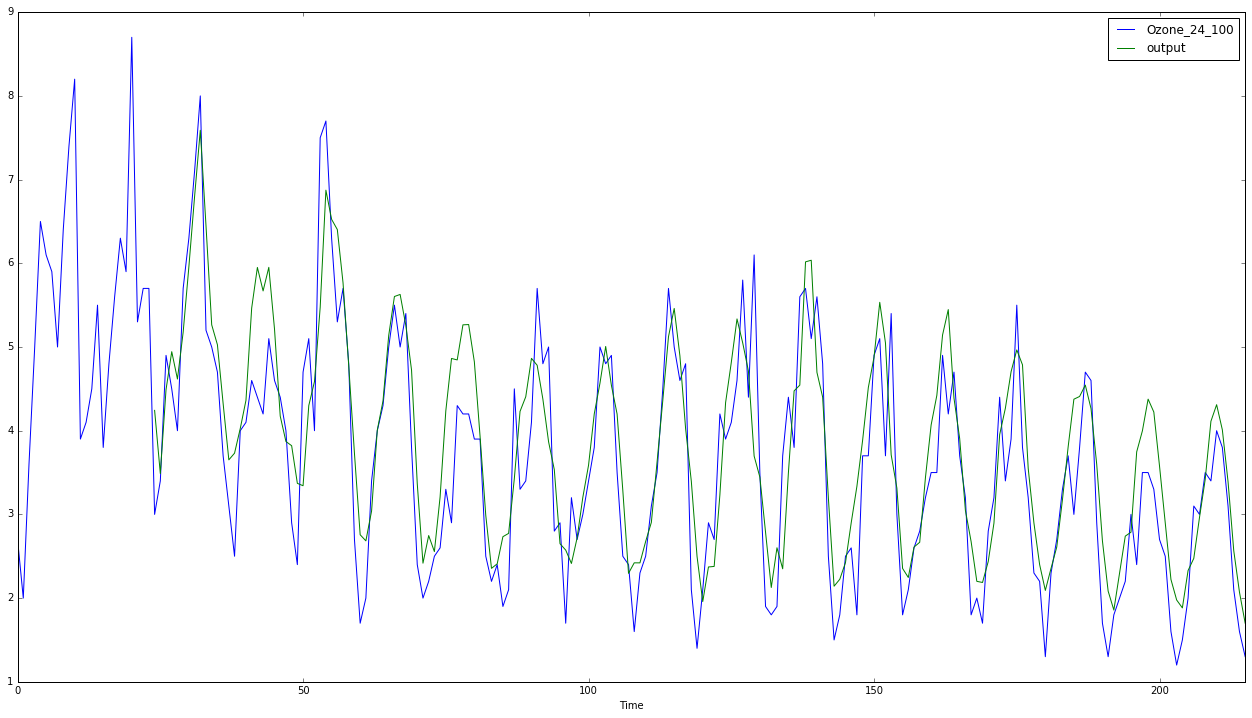

In [34]:
full_test('../data/ozone-la.csv', 'Ozone', 24, 100)

In [31]:
#for ep in [10 , 40, 160, 640]:
#    for lags in [8 ,32]:
#        full_test('../data/passengers_train.csv', 'AirPassengers',lags, ep)


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Train on 67 samples, validate on 17 samples
Epoch 1/100
0s - loss: 0.1148 - val_loss: 0.2493
Epoch 2/100
0s - loss: 0.0311 - val_loss: 0.0856
Epoch 3/100
0s - loss: 0.0129 - val_loss: 0.0469
Epoch 4/100
0s - loss: 0.0109 - val_loss: 0.0352
Epoch 5/100
0s - loss: 0.0100 - val_loss: 0.0298
Epoch 6/100
0s - loss: 0.0095 - val_loss: 0.0272
Epoch 7/100
0s - loss: 0.0081 - val_loss: 0.0217
Epoch 8/100
0s - loss: 0.0074 - val_loss: 0.0209
Epoch 9/100
0s - loss: 0.0067 - val_loss: 0.0188
Epoch 10/100
0s - loss: 0.0059 - val_loss: 0.0141
Epoch 11/100
0s - loss: 0.0054 - val_loss: 0.0107
Epoch 12/100
0s - loss: 0.0048 - val_loss: 0.0091
Epoch 13/100
0s - loss: 0.0048 - val_loss: 0.0075
Epoch 14/100
0s - loss: 0.0040 - val_loss: 0.0084
Epoch 15/100
0s - loss: 0.0038 - val_loss: 0.0058
Epoch 16/100
0s - loss: 0.0035 - val_loss: 0.0051
Epoch 17/100
0s - loss: 0.0035 - val_loss: 0.0045
Epoch 18/100
0s - loss: 0.0034 - val_loss: 0.0044
Epoch 19/100
0s - loss: 0.0031 - val_loss: 0.0042
Epoch 20/100
0s

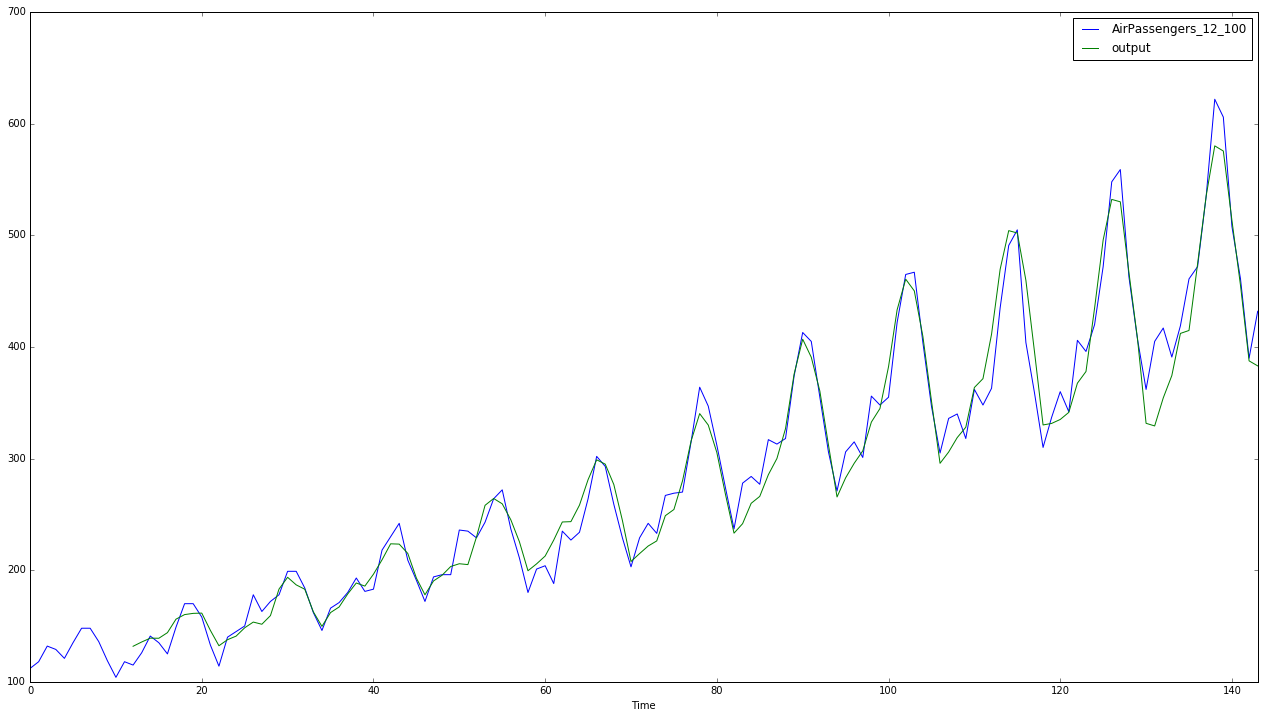

In [33]:
full_test('../data/passengers_train.csv', 'AirPassengers', 12, 100)

In [10]:
callbacks.EarlyStopping?

In [11]:
mod0 = Sequential()


In [12]:
mod0.fit?

In [13]:
LSTM?